# Image Caption Generator using Deep Learning on Flickr8K dataset
Generating a caption for a given image is a challenging problem in the deep learning domain. In this notebook we will use different computer vision and NLP techniques to recognize the context of an image and describe them in a natural language like English. We will build a working model of the image caption generator using CNN (Convolutional Neural Networks) and LSTM (Long short term memory). For training our model we will use Flickr8K dataset which consists of 8000 unique images. You can download this dataset from kaggle.


## Imports

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add
from tensorflow.keras.utils import to_categorical,plot_model

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("adityajn105/flickr8k")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'flickr8k' dataset.
Path to dataset files: /kaggle/input/flickr8k


In [3]:
BASE_DIR = path

# VGG16 Model
We use vgg16 model for our pretrained cnn model which is trained on imagenet dataset

In [4]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


## Extracting the feature vectors for all images
Now we will give an image as an input to our model but unlike humans, machines cannot understand the image by seeing them. So we need to convert the image into an encoding so that the machine can understand the patterns in it. For this task, I'm using transfer learning i.e, we use a pre-trained model that has been already trained on large datasets and extract the features from these models and use them for our work. Here I'm using the vgg16 model which has been trained on Imagenet dataset that had 1000 different classes to classify. We can directly import this model from Keras.applications module. We need to remove the last classification layer to get the (4096, ) dimensional feature vector from vgg16 model.

In [8]:
# extract features from the images
features = {}
directory = os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
    # load the image from file
    img_path = os.path.join(directory,img_name)
    # load images and set target size
    image = load_img(img_path,target_size = (224,224))
    # convert image to array
    image = img_to_array(image)
    # reshape the image
    image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2])) # (1,299,299,3)
    # preprocess the input
    image = preprocess_input(image)
    # extract features
    feature  = model.predict(image,verbose =0)
    # get image id
    image_id = img_name.split('.')[0]
    # store the feature
    features[image_id] = feature


  0%|          | 0/8091 [00:00<?, ?it/s]

In [12]:
pickle.dump(features,open('/content/drive/MyDrive/features_vgg.pkl','wb'))

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
with open('/content/drive/MyDrive/features_vgg.pkl','rb') as f:
  features = pickle.load(f)

In [6]:
len(features)

8091

In [7]:
features['1093737381_b313cd49ff']

array([[2.8823543, 2.2597637, 0.       , ..., 0.       , 5.161185 ,
        1.5296768]], dtype=float32)

# Load the captions Data


The format of our file is image and caption separated by a newline (“\n”) i.e it consists of the name of the image followed by a space and the description of the image in CSV format. Here we need to map the image to its descriptions by storing them in a dictionary.

In [8]:
# load captions.txt
with open(os.path.join(BASE_DIR,'captions.txt'), 'r') as f:
  next(f)
  captions_doc = f.read()

In [9]:
# create mapping of images of captions
mapping = {}
# preprocess the tokens
for line in tqdm(captions_doc.split('\n')):
  # splite the line by comma(,)
  tokens = line.split(',')
  if len(line) < 2:
    continue
  # splite image_ids, captions
  image_id, caption = tokens[0], tokens[1:]
  # remove extension from image_id
  image_id = image_id.split('.')[0]
  # convert captions_list into string
  caption = " ".join(caption)
  # append caption to corresponding image_id
  if image_id not in mapping:
    mapping[image_id] = []
  mapping[image_id].append(caption)


  0%|          | 0/40456 [00:00<?, ?it/s]

# Preprocess the Captions

One of the main steps in NLP is to remove noise so that the machine can detect the patterns easily in the text. Noise will be present in the form of special characters such as hashtags, punctuation and numbers. All of which are difficult for computers to understand if they are present in the text. So we need to remove these for better results. Additionally you can also remove stop words and perform Stemming and Lemmatization by using NLTK library.

In [10]:
def clean(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      # take one caption at a time
      caption = captions[i]
      # preprocessing steps
      # convert to lower case
      caption = caption.lower()
      # remove other punctuations
      caption = caption.replace('[^A-Za-z]','')
      # replace extra spaces with single spaces
      caption = caption.replace('\s+', ' ')
      # insert start and end token for generation
      caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
      # move back
      captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-810413300.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [11]:
mapping['1093737381_b313cd49ff']

['A woman in a blue dress stands with a chalk portrait of two children playing by a stream .',
 'A woman standing in front of a chalk drawing',
 'A woman stands next to a chalk drawing in front of a barn-like structure .',
 'A woman stands outside near an elaborate chalk illustration .',
 'A woman wearing a blue dress is drawing a picture of a boy and a girl on the sidewalk with sidewalk chalk .']

In [12]:
clean(mapping)

In [13]:
mapping['1093737381_b313cd49ff']

['startseq woman in blue dress stands with chalk portrait of two children playing by stream endseq',
 'startseq woman standing in front of chalk drawing endseq',
 'startseq woman stands next to chalk drawing in front of barn-like structure endseq',
 'startseq woman stands outside near an elaborate chalk illustration endseq',
 'startseq woman wearing blue dress is drawing picture of boy and girl on the sidewalk with sidewalk chalk endseq']

# Tokenization and Padding

In [14]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [15]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
len(all_captions)

40455

In [17]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
pickle.dump(tokenizer,open('tokenizer.pkl','wb'))

In [19]:
# get maximum length of the captions available
max_length = max(len(caption.split()) for caption in all_captions)

# Train Test Split

In [20]:
image_ids = list(mapping.keys())

In [21]:
split = int(len(image_ids) * 0.75)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
len(train)

6068

In [23]:
len(test)

2023

In [24]:
seq = tokenizer.texts_to_sequences(['woman standing in front of a chalk drawing'])[0]
seq

[17, 37, 3, 47, 11, 54, 1395, 1633]

# Data Generator
Creating a Data Generator for Model Training
Since training a deep learning model requires handling large datasets, we implement a data generator to yield batches of image features and corresponding tokenized captions. This approach improves memory efficiency by processing data dynamically rather than loading everything into memory at once.

In [25]:
# create data generator to get data in batch
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
  # loop over images
  X1,X2,y = list(), list(), list()
  # this is useful for reaching the batch size or not i.e n = 0
  n = 0
  while 1:
    for key in data_keys:
      n +=1
      captions = mapping[key]
      # preprocess each captions
      for caption in captions:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([caption])[0]
        # split the sequence in X,y pairs
        for i in range(1,len(seq)):
          # splite into input and output paris
          in_seq,out_seq = seq[:i],seq[i]
          # pad input sequences
          in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
          # encode output sequences
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
          # appending in X1, X2, y
          X1.append(features[key][0])
          X2.append(in_seq)
          y.append(out_seq)
      if n == batch_size:
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
        yield ((X1, X2), y)
        X1, X2, y = list(), list(), list()
        n = 0

# Model Building
Building the Image Captioning Model
We define the architecture of our Image Captioning model using the Keras Functional API. The model consists of:

- Image Feature Extractor (CNN Output Processing): The input image feature vector (4096-dimensional) is normalized using Batch Normalization. A Dense layer transforms it into a 256-dimensional vector to match the LSTM output size.
- Text Sequence Processor (LSTM-based Decoder): The tokenized captions are passed through an Embedding layer, mapping words to dense vector representations. An LSTM layer processes the embedded sequence to generate a feature representation.
- Decoder and Final Prediction: The processed image and text features are combined using an addition operation. A Dense layer refines the representation before making the final word prediction using a softmax activation function





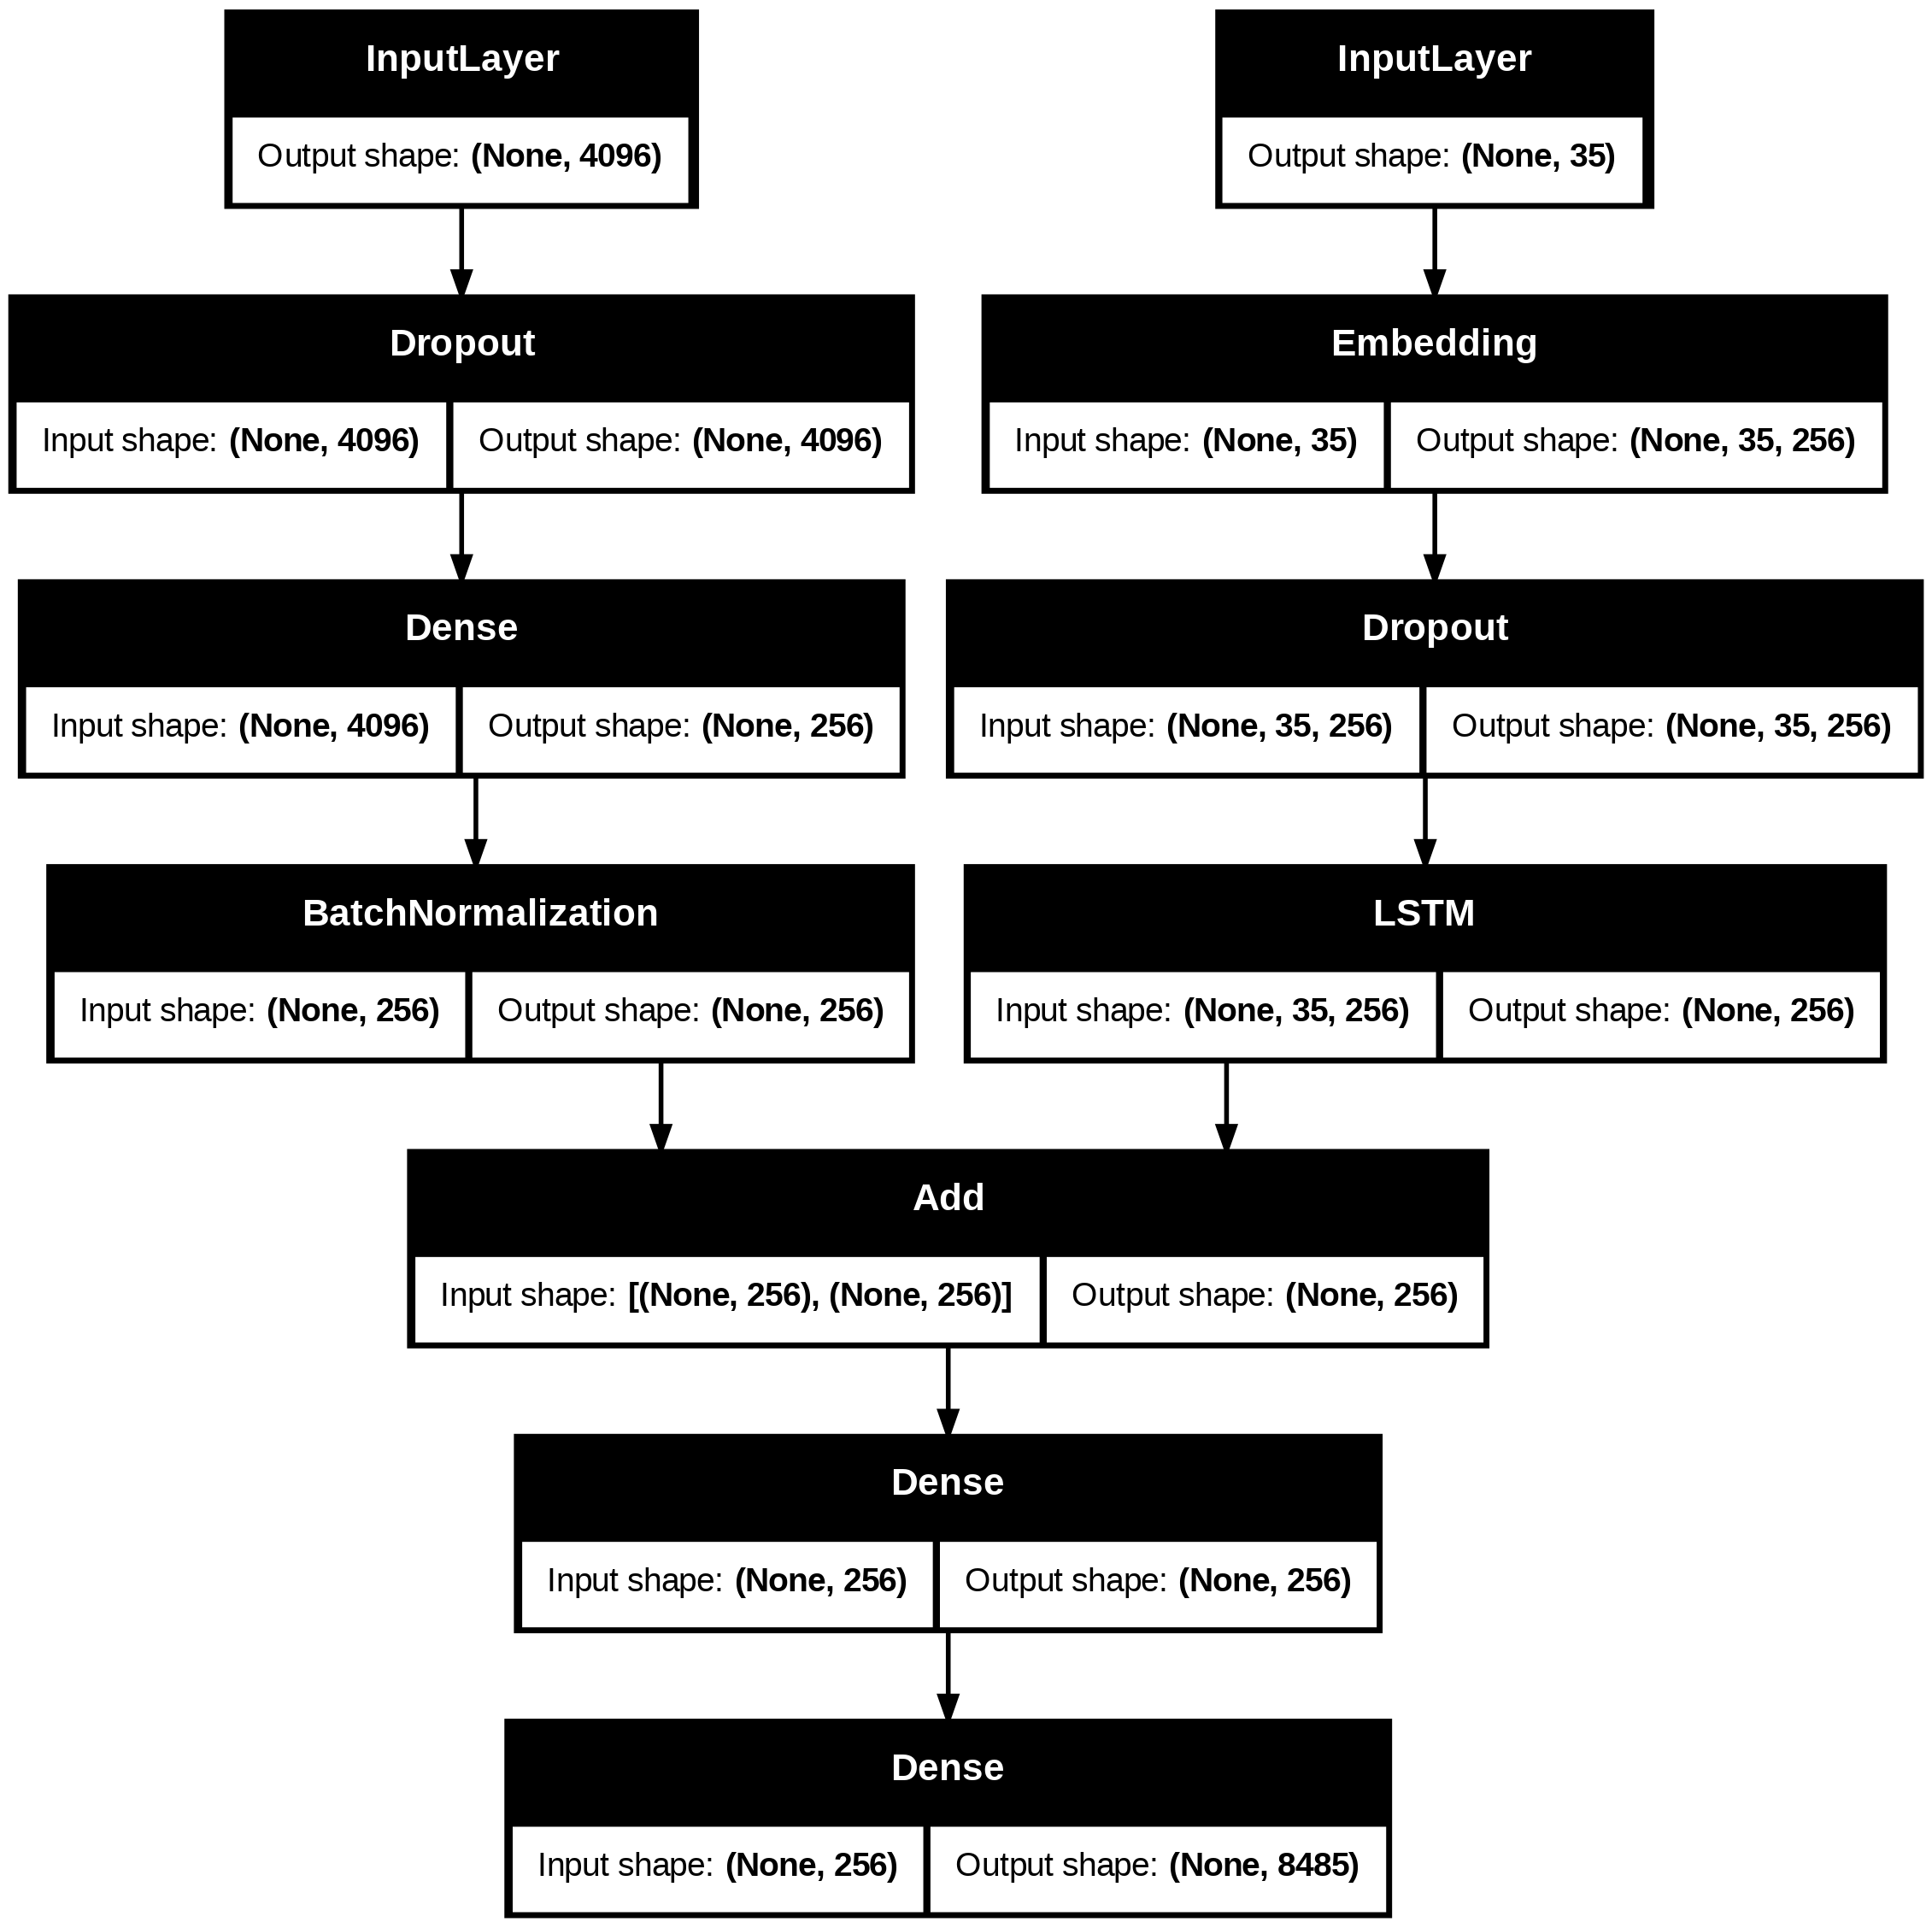

In [26]:
from tensorflow.keras.layers import BatchNormalization
# Image Feature Model
inputs1 = Input(shape = (4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256,activation = 'relu')(fe1)
fe3 = BatchNormalization()(fe2)
# Sequence feature layers
inputs2 = Input(shape =(max_length,))
se1 = Embedding(vocab_size,256)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe3,se3])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

model = Model(inputs = [inputs1,inputs2], outputs = outputs)
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam')

# plot the model

plot_model(model, show_shapes = True)

In [27]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 4096)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 35)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 4096)      │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 35, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │  1,048,832 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 35, 256)   │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 256)       │    525,312 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  2,180,645 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,993,765 (22.86 MB)

 Trainable params: 5,993,253 (22.86 MB)

 Non-trainable params: 512 (2.00 KB)

In [28]:
len(features)

8091

In [29]:
# train the model
epochs = 17
batch_size = 32
steps = len(train)//batch_size
for i in range(epochs):
  # create data generator
  generator = data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
  # fit for one epoch
  model.fit(generator, steps_per_epoch=steps, verbose=1)


189/189 ━━━━━━━━━━━━━━━━━━━━ 51s 236ms/step - loss: 6.0816
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - loss: 4.3142
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - loss: 3.7658
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 239ms/step - loss: 3.4476
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 233ms/step - loss: 3.2067
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 231ms/step - loss: 3.0097
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - loss: 2.8531
189/189 ━━━━━━━━━━━━━━━━━━━━ 43s 229ms/step - loss: 2.7249
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - loss: 2.6233
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 237ms/step - loss: 2.5381
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 230ms/step - loss: 2.4601
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - loss: 2.3945
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 232ms/step - loss: 2.3361
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - loss: 2.2807
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 234ms/step - loss: 2.2310
189/189 ━━━━━━━━━━━━━━━━━━━━ 44s 235ms/step - loss: 2.1847
189/189 ━━━━━━━━━━━━━━━━━━━━ 45s 238ms/step - loss: 2.13

In [30]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/best_model_vgg.h5')

# Generate Captions Using Greedy Search for the image

Generating Captions Using Greedy Search
We implement a greedy search algorithm to generate captions by predicting one word at a time. The model selects the word with the highest probability at each step until the end token is reached.



In [31]:
def idx_to_word(num,tokenizer):
  for word,index in tokenizer.word_index.items():
    if index == num:
      return word

  return None

In [32]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'

    for i in range(max_length):
        # convert text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], maxlen=max_length)
        # ensure both are numpy arrays
        image_input = np.array(image).reshape((1, image.shape[1]))  # e.g. (1, 4096)
        sequence_input = np.array(sequence)

        # predict next word
        yhat = model.predict([image_input, sequence_input], verbose=0)

        # get index with max probability
        yhat = np.argmax(yhat)
        # map index to word
        word = tokenizer.index_word.get(yhat, None)
        if word is None:
            break
        # append word
        in_text += ' ' + word
        if word == 'endseq':
            break

    return in_text

In [33]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
  # get actual caption
  captions = mapping[key]
  # predict the caption for image
  y_pred = predict_caption(model, features[key], tokenizer, max_length)
  actual_caption = [caption.split() for caption in captions]
  actual.append(actual_caption)
  predicted.append(y_pred.split())

# calculate BELU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual,predicted,weights = (0.5,0.5,0,0,0)))

  0%|          | 0/2023 [00:00<?, ?it/s]

BLEU-1: 0.489589
BLEU-2: 0.286914


In [44]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_captions_greed(image_name):
  # create image id
  image_id = image_name.split(".")[0]
  img_path = os.path.join(BASE_DIR,'Images',image_name)
  image = Image.open(img_path)
  # actual captions
  captions = mapping[image_id]
  for caption in captions:
    caption = (" ".join(caption.split()[1:]))
    print(" ".join(caption.split()[:-1]))

  # predicted captions
  predicted_captions = predict_caption(model,features[image_id],tokenizer,max_length)
  predicted_captions = (" ".join(predicted_captions.split()[1:]))
  print(" ".join(predicted_captions.split()[:-1]))

  # visualize the image
  plt.imshow(image)


man is standing in front of skyscraper
man stands in front of skyscraper
man stands in front of very tall building
behind the man in red shirt stands large skyscraper
there is skyscraper in the distance with man walking in front of the camera
the man is standing in front of skyscraper


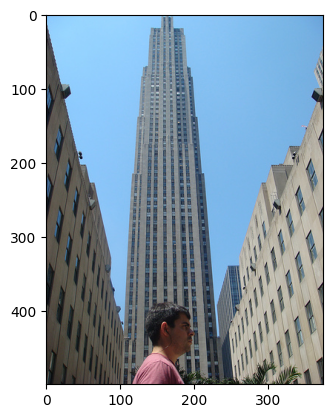

In [47]:
generate_captions_greed('1032460886_4a598ed535.jpg')

male does an open leg trick while doing wheelie on his bike
man is doing wheelie on motorcycle while stretching his legs outwards
"a man with red black and white jacked on is riding on motorcycle ."
man puts legs up in air while riding bike
person riding bike doing while
man in red and black uniform is turning to the ball on the ground


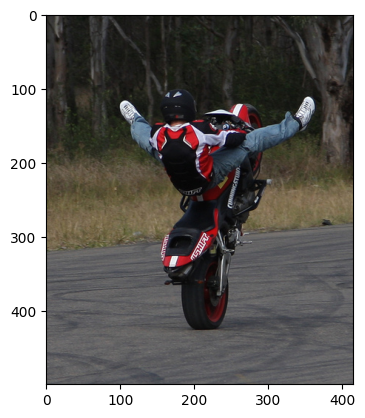

In [46]:
generate_captions_greed(f'{test[23]}.jpg')

two hikers are climbing through rocky and snowy passage in the mountains
two mountain climbers walk through pass with snowy mountains behind them
two mountain-climbing hikers ascend rocky path through patches of snow
"two people are climbing up huge snowy mountain ."
two people are walking up mountain
person overlooking snowy mountain


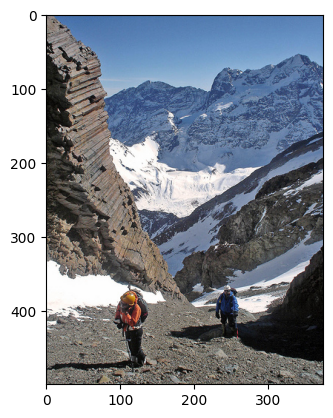

In [49]:
generate_captions_greed(f'{test[234]}.jpg')

boy in white shirt and green helmet is riding skateboard down some steps
child in helmet and gloves on skateboard is airborne
little boy in helmet is doing tricks on skateboard
young boy is completing jump on skateboard
the boy does skateboard trick
boy in blue shirt jumps in the air


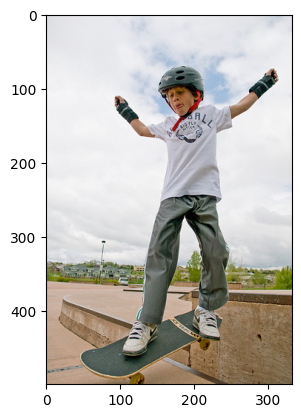

In [52]:
generate_captions_greed(f'{test[4]}.jpg')

"a formation on big field with people wearing red white and blue"
many people in formation on field
marching bands in formation on field
the crowd stood in many different lines in the open field
the group of people make single file lines on the field
group of people sitting on the grass


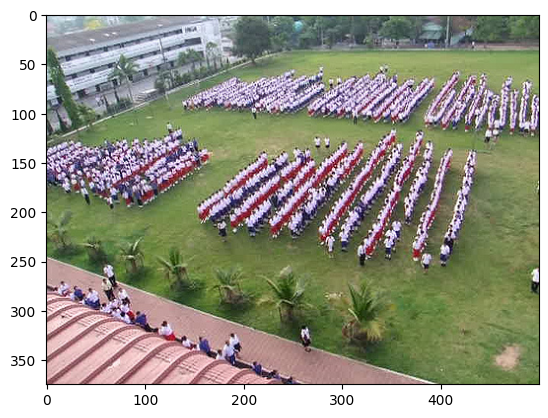

In [58]:
generate_captions_greed(f'{test[1]}.jpg')

# Generating Captions Using Beam Search
We implement beam search to generate captions by exploring multiple possible sequences at each step. This method selects the top K probable sequences.



In [37]:
import numpy as np

def predict_caption_beam(model, image, tokenizer, max_length, beam_width=3):
    """
    Generate caption for an image using Beam Search.
    """

    # Start with the start token
    start_seq = ['startseq']
    # Each element: (sequence_so_far, probability)
    beam = [(start_seq, 0.0)]

    for _ in range(max_length):
        candidates = []
        # Expand each sequence in the beam
        for seq, score in beam:
            # Stop if the sentence already ended
            if seq[-1] == 'endseq':
                candidates.append((seq, score))
                continue

            # Convert sequence to tokens
            sequence = tokenizer.texts_to_sequences([' '.join(seq)])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)

            # Predict next word probabilities
            yhat = model.predict([image, sequence], verbose=0)
            yhat = np.log(yhat[0] + 1e-10)  # use log for numerical stability

            # Get top beam_width words
            top_indexes = np.argsort(yhat)[-beam_width:]

            # Create new candidate sequences
            for idx in top_indexes:
                word = tokenizer.index_word.get(idx)
                if word is None:
                    continue
                new_seq = seq + [word]
                new_score = score + yhat[idx]
                candidates.append((new_seq, new_score))

        # Sort all candidates by score (descending)
        ordered = sorted(candidates, key=lambda tup: tup[1], reverse=True)
        # Select the top beam_width sequences
        beam = ordered[:beam_width]

    # Pick the sequence with the best score
    final_seq = beam[0][0]

    # Join words into sentence, removing start and end tokens
    caption = ' '.join([word for word in final_seq if word not in ['startseq', 'endseq']])
    return caption


In [40]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def generate_captions(image_name, model, features, tokenizer, mapping, max_length, beam_width=5):
    """
    Display an image, show its actual captions, and generate a predicted caption using Beam Search.
    """

    # --- Step 1: Prepare the image and ID ---
    image_id = image_name.split(".")[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)

    if not os.path.exists(img_path):
        print(f"❌ Image not found at path: {img_path}")
        return

    image = Image.open(img_path)

    # --- Step 2: Show the actual captions ---
    print("🟢 Actual Captions:")
    if image_id in mapping:
        for i, caption in enumerate(mapping[image_id], 1):
            # Clean startseq and endseq for readability
            cleaned_caption = caption.replace("startseq", "").replace("endseq", "").strip()
            print(f"{i}. {cleaned_caption}")
    else:
        print("No actual captions found for this image.")

    # --- Step 3: Predict caption using Beam Search ---
    print("\n🚀 Predicted Caption (Beam Search):")
    if image_id in features:
        feature_vector = features[image_id].reshape((1, 4096))
        predicted_caption = predict_caption_beam(model, feature_vector, tokenizer, max_length, beam_width)
        print(predicted_caption)
    else:
        print(f"⚠️ Features not found for image ID: {image_id}")
        return

    # --- Step 4: Visualize the image ---
    plt.imshow(image)
    plt.axis("off")
    plt.show()


🟢 Actual Captions:
1. "a formation on big field with people wearing red white and blue"
2. many people in formation on field
3. marching bands in formation on field
4. the crowd stood in many different lines in the open field
5. the group of people make single file lines on the field

🚀 Predicted Caption (Beam Search):
group of people sitting on the grass


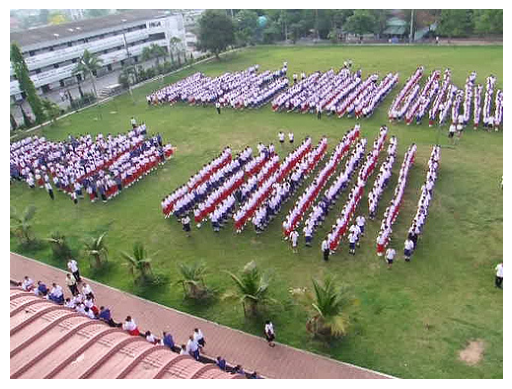

In [48]:
generate_captions(f"{test[1]}.jpg", model, features, tokenizer, mapping, max_length, beam_width=5)

🟢 Actual Captions:
1. man holding digital camera standing outside of huge building
2. man in blue shirt holding camera
3. "a man in blue t-shirt holds camera
4. man wearing blue holds camera
5. the man in blue shirt is holding camera near to boy wearing backpack

🚀 Predicted Caption (Beam Search):
man and woman are standing in front of building


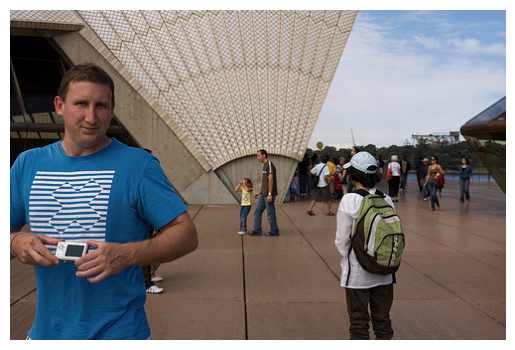

In [53]:
generate_captions(f"{test[0]}.jpg", model, features, tokenizer, mapping, max_length, beam_width=5)

🟢 Actual Captions:
1. boy is standing on one hand on the pavement
2. kid in sportswear is attempting one-handed stand on trampoline
3. small boy does handstand on one hand
4. young boy does one-armed handstand on concrete
5. the boy is doing handstand on the pavement

🚀 Predicted Caption (Beam Search):
person is on the pavement in the air


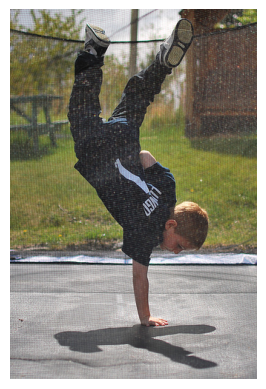

In [55]:
generate_captions(f"{test[53]}.jpg", model, features, tokenizer, mapping, max_length, beam_width=5)

🟢 Actual Captions:
1. guy racing his motorcycle
2. man on motorcycle is racing at track
3. motorcycle goes by crowd with its rear wheel in the air
4. person riding racing motorcycle while other people watch
5. spectators watching motorcyclist ground around track

🚀 Predicted Caption (Beam Search):
man on motorcycle on track


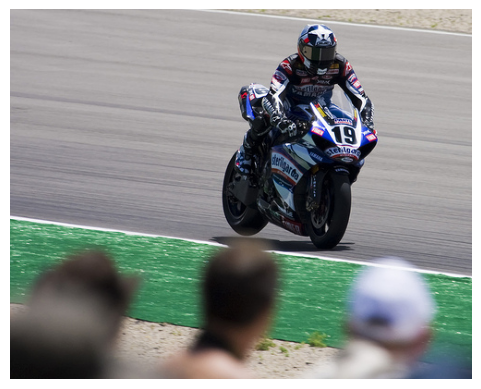

In [57]:
generate_captions(f"{test[383]}.jpg", model, features, tokenizer, mapping, max_length, beam_width=5)

# Conclusion
We trained our model and our bleu score is almost 50 which is quite good but the best part is our model perform well on this data . Some predictions are not good because we use simple lstm with only 256 units we increase these units or we train on more epochs like 20,25 and we also use attention mechanism for better capturing the context. Implementing the model is a time consuming task as it involved lot of testing with different hyperparameters to generate better captions. The model generates good captions for the provided image but it can always be improved.
We can also use Transformer and I think we should must try this becuase it performs good on this dataset and it performs well than other tecniques like attention mechanism and simple lstm.